In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import openmc.data as data
import warnings
import sys
sys.path.append('../../')
import fission_products


xs_dataframe = pd.read_csv('../mgxs/output.txt')
U233_FY = fission_products.specific_fission("233u")

$ \frac{\partial C_i}{\partial t} = C_j\Bigr[\lambda_j + \sigma_{i\rightarrow j}\phi\Bigr] + \Sigma_f\phi - C_i\Bigr[\lambda_i + \sigma_{i\neq i}\phi\Bigr]$

$ C_{i, t+1} = C_{i,t} + \Delta t\cdot \biggr[C_j\Bigr[\lambda_j + \sigma_{i\rightarrow j}\phi\Bigr] + \gamma_i\frac{P}{E_{fission}} - C_i\Bigr[\lambda_i + \sigma_{i\neq i}\phi\Bigr]\biggr]$

In [2]:
class Nuclide:
    def __init__(self, name: str, removal_efficiency: float = 0., IC: float = 0):
        try:
            self._lambda = data.decay_constant(name)
        except:
            self._lambda = 0.0
        
        try:
            self._gamma = U233_FY[name]
        except KeyError:
            print(f'{name} does not have a fission yield!!')
            self._gamma = 0.0
            
        try:
            self._absxs = xs_dataframe[name].values[0] * 1e-24
        except KeyError:
            self._absxs = 0.0

        try:
            self._transmute = xs_dataframe[name].values[1] * 1e-24
        except KeyError:
            self._transmute = 0.0

        self.IC = IC
            
        self._epsilon = removal_efficiency
        return

In [3]:
def deplete_chain_xs(power: float = 3e9, dt: float = 60,
                    num_steps: int = 60*24*50, core_residency_fraction: float = .2,
                    ef: float = 200, **kwargs):
    
    time = np.linspace(0, num_steps*dt, num_steps+1)
    joules_per_fission = ef*1.60218e-13
    fissions_per_second = power / joules_per_fission * core_residency_fraction 

    flux = 2.6e14 * core_residency_fraction # veraged thermal
    
    num_nucs = len(kwargs)
    nuclides = [nuclide for nuclide in kwargs.values()]
    concentrations = np.zeros((num_nucs, time.size))
    for i in range(num_nucs):
        concentrations[i][0] = nuclides[i].IC

    for step in range(1, time.size):
        
        for i in range(num_nucs):
            conc = concentrations[i]
            nuc = nuclides[i]
            fy = nuc._gamma * fissions_per_second 
            idec = nuc._lambda *conc[step - 1]
            iabs = nuc._absxs * conc[step - 1] * flux
            irem = conc[step - 1] * nuc._epsilon
            rhs = fy - idec - iabs - irem
            if i > 0:
                par = nuclides[i - 1]
                par_conc = concentrations[i - 1]
                ptra = par._transmute * par_conc[step - 1] * flux 
                
                pdec = par_conc[step - 1] * par._lambda
                rhs += pdec + ptra
                
            conc[step] = conc[step - 1] + dt * rhs

    for i, nuc in enumerate(nuclides):
        nuc.atoms = concentrations[i][1:]
        
    return time[1:]

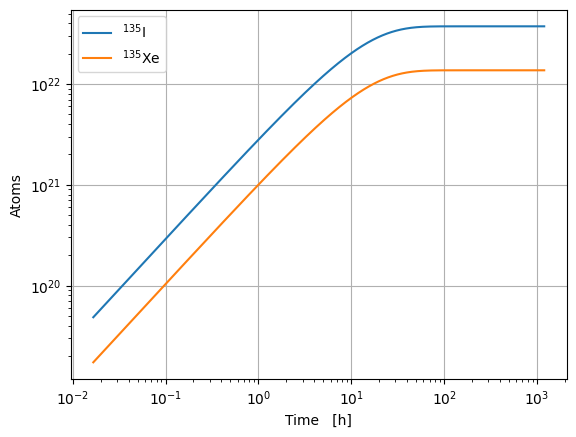

In [4]:
Xe135 = Nuclide('Xe135')
I135 = Nuclide('I135')
time = deplete_chain_xs(Xe135 = Xe135, I135 = I135)
fig, ax = plt.subplots()
ax.loglog(time/3600, I135.atoms, label = '$^{135}$I')
ax.loglog(time/3600, Xe135.atoms, label = '$^{135}$Xe')
ax.legend()
ax.grid()
ax.set_ylabel('Atoms')
ax.set_xlabel('Time   [h]')
fig.savefig('XeI.png', dpi=600)
plt.show()

Th232 does not have a fission yield!!
Pa233 does not have a fission yield!!


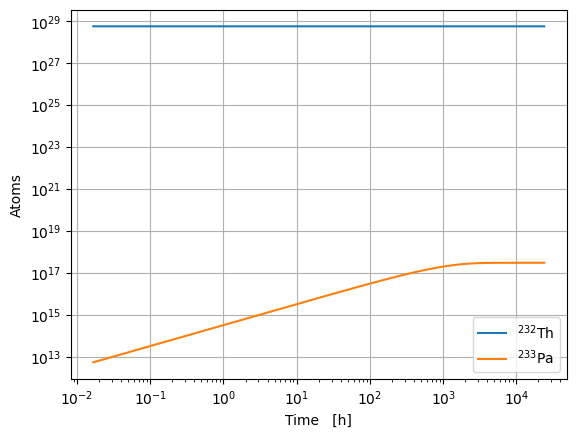

In [7]:
'''LiF-BeF2-ThF4-UF4
71.7 16.0 2.0 0.3 mole %'''
mli7 = data.atomic_mass('Li7')
mf = data.atomic_weight('F')
mbe = data.atomic_weight('Be')
mth = data.atomic_weight('Th')
mu = data.atomic_mass('U233')

M = (mli7 + mf) * 71.7 + (mbe + 2*mf) * 16 + (mth + 4*mf) * 2 + (mu + 4*mf) * 0.3
M /= 100

V = 48710000
mflibe = 3.2839 * V

thIC = (mflibe / M * 0.02) * sp.constants.Avogadro

Th232 = Nuclide('Th232', IC=thIC)
Pa233 = Nuclide('Pa233')

time = deplete_chain_xs(num_steps=60*24*1000, Th232 = Th232, Pa233 = Pa233)
fig, ax = plt.subplots()
ax.loglog(time/3600, Th232.atoms, label = '$^{232}$Th')
ax.loglog(time/3600, Pa233.atoms, label = '$^{233}$Pa')
ax.legend()
ax.grid()
ax.set_ylabel('Atoms')
ax.set_xlabel('Time   [h]')
fig.savefig('ThPa.png',dpi=600)
plt.show()

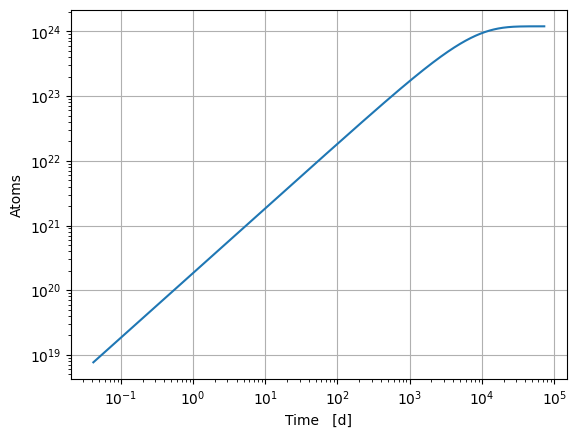

In [6]:
T = Nuclide('H3')
time = deplete_chain_xs(dt = 3600, num_steps=24*365*200, T=T)
fig, ax = plt.subplots()
ax.loglog(time/3600/24, T.atoms)
ax.grid()
ax.set_ylabel('Atoms')
ax.set_xlabel('Time   [d]')
fig.savefig('')
plt.show()